In [1]:
from dataset import (
    get_dataset, 
    save_map, 
    save_pred_map_to_tif
)
from metrics import (
    get_metrics,
    get_classification_metrics,
    get_feature_importances, 
    get_catboost_importances, 
)
from vis import (
    plot_image,
    plot_mask,
    plot_SCL,
    draw_maps,
)

import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import wandb
import rasterio
import numpy as np
import tifffile as tiff
import wandb
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2   

/beegfs/home/alina.smolina/forest-co2/dataset.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_S2B_list = [
    './data/tile_UTM38N/20180730/',
    './data/tile_UTM38N/20180804/',
    './data/tile_UTM38N/20180827/',
    './data/tile_UTM38N/20180911/',
    './data/tile_UTM38N/20190608/',
    './data/tile_UTM38N/20190613/',
    './data/tile_UTM38N/20200604/',
    './data/tile_UTM38N/20200709/',
]

channels = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target = 'age'

In [3]:
# Get table with types and ages
y0, x0 = 6000, 0
window_n = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

y0, x0 = 0, 5700
window_r = Window.from_slices((y0, y0 + 7000), (x0, x0 + 10000))


### Test
y0, x0 = 7500, 2700
window_k = Window.from_slices((y0, y0 + 3000), (x0, x0 + 1200))

In [7]:
## Stacking of several dates
def stack_several_dates_dataset(path_S2B_list, 
                              target, 
                              channels_list=['B02'], 
                              window=None, 
                              indices=False):
    dataset_list = []
    ch_list = channels_list + [target]

    for path_S2B in path_S2B_list:
        dataset = get_dataset(
            path_S2B, 
            channels_list=ch_list, 
            window=window, 
            visualise=False, 
            indices=indices)
        
        dataset = dataset[dataset[target] > 0]
        
        #### классификация:
        # dataset = dataset.query('(`1layer_main_species` == 1) | (`1layer_main_species` == 2) | (`1layer_main_species` == 3) | (`1layer_main_species` == 4) | (`1layer_main_species` == 5) | (`1layer_main_species` == 9)')

        dataset_list.append(dataset)

    dataset = pd.concat(dataset_list)
        
    return dataset

In [8]:
dataset = pd.concat([
    stack_several_dates_dataset(path_S2B_list, target, channels_list=channels, window=window_n, indices=True),
    stack_several_dates_dataset(path_S2B_list, target, channels_list=channels, window=window_r, indices=True),
])

Y = dataset[target]
X = dataset.drop(labels=[target, 'x', 'y'], axis=1)

In [14]:
X_train, X_test1, Y_train, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=0)

print(len(X_train), len(X_val), len(X_test1), len(X_test))
print(f'Train proportion: {len(X_train)/len(X):.3f}')
print(f'Val proportion: {len(X_val)/len(X):.3f}')
print(f'Test_random proportion: {len(X_test1)/len(X):.3f}')
print(f'Test_window proportion: {len(X_test)/len(X):.3f}')

60803318 10729998 17883329 10865177
Train proportion: 0.680
Val proportion: 0.120
Test_random proportion: 0.200
Test_window proportion: 0.122


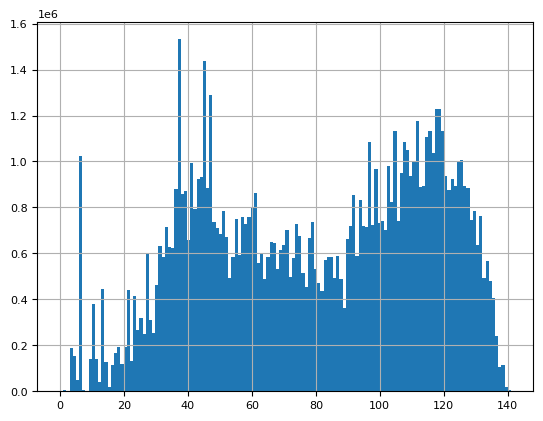

In [15]:
%matplotlib inline
Y.hist(bins=142, range=(0, 141));

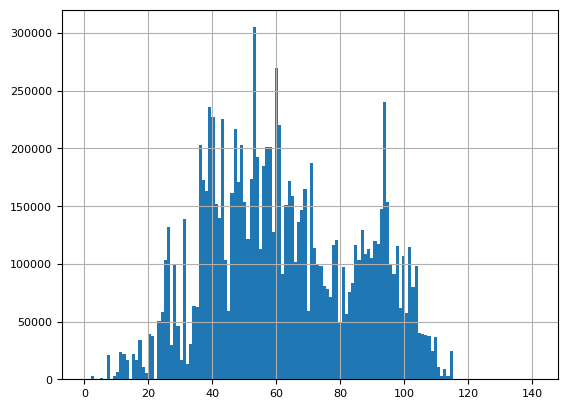

In [16]:
%matplotlib inline
Y_test.hist(bins=142, range=(0, 141));

In [17]:
run = wandb.init(
  project="forest-co2",
  notes=f"Channels {channels}. Date: {path_S2B_list}. SCL=4",
  tags=[target]
)

wandb: Currently logged in as: nali. Use `wandb login --relogin` to force relogin


In [20]:
from catboost import CatBoostRegressor, Pool

train_data = Pool(data=X_train, 
                  label=Y_train,
                  # cat_features=['catboost_types124']
                 )
val_data = Pool(data=X_val, 
                label=Y_val,
                # cat_features=['catboost_types124']
               )

params = {'learning_rate': 0.35, 
          'loss_function': 'RMSE',
          'max_depth': 8,
          # 'custom_metric': ['R2', 'MAE'], 
          'eval_metric': 'MAPE',
          'iterations': 10000,
          'verbose': 1000, 
          'task_type': 'GPU'
         }

model = CatBoostRegressor(**params)

model.fit(train_data, eval_set=val_data, plot=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6237411	test: 0.6240584	best: 0.6240584 (0)	total: 338ms	remaining: 56m 19s
1000:	learn: 0.2532255	test: 0.2538185	best: 0.2538185 (1000)	total: 6m 29s	remaining: 58m 24s
2000:	learn: 0.2488268	test: 0.2497679	best: 0.2497679 (2000)	total: 12m 52s	remaining: 51m 28s
3000:	learn: 0.2464726	test: 0.2477333	best: 0.2477333 (3000)	total: 19m 11s	remaining: 44m 45s
4000:	learn: 0.2447829	test: 0.2463409	best: 0.2463317 (3997)	total: 25m 30s	remaining: 38m 15s
5000:	learn: 0.2435279	test: 0.2453623	best: 0.2453620 (4987)	total: 31m 49s	remaining: 31m 48s
6000:	learn: 0.2424399	test: 0.2445510	best: 0.2445415 (5995)	total: 38m 5s	remaining: 25m 23s
7000:	learn: 0.2415266	test: 0.2439055	best: 0.2439010 (6997)	total: 44m 23s	remaining: 19m
8000:	learn: 0.2407740	test: 0.2434107	best: 0.2434034 (7990)	total: 50m 40s	remaining: 12m 39s
9000:	learn: 0.2400651	test: 0.2429459	best: 0.2429372 (8991)	total: 56m 57s	remaining: 6m 19s
9999:	learn: 0.2394457	test: 0.2425595	best: 0.2425581 

In [21]:
model.save_model(f"./weights/exp={run.name}_id={run.id}")

In [22]:
model.save_model(
    f"./weights/exp={run.name}_id={run.id}.json",
    format="json")

In [23]:
wandb.sklearn.plot_feature_importances(model, model.feature_names_)

In [28]:
test_list = []
ch_list = channels + [target]

for path_S2B in path_S2B_list:
    dataset = get_dataset(
        path_S2B, 
        channels_list=ch_list, 
        window=window_k, 
        visualise=False, 
        indices=True)

    dataset = dataset[dataset[target] > 0]

    #### классификация:
    # dataset = dataset.query('(`1layer_main_species` == 1) | (`1layer_main_species` == 2) | (`1layer_main_species` == 3) | (`1layer_main_species` == 4) | (`1layer_main_species` == 5) | (`1layer_main_species` == 9)')

    test_list.append(dataset)
    
#### пригодится для метрик

In [24]:
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_absolute_error, 
    mean_squared_error, 
    confusion_matrix, 
    classification_report
)

In [33]:
names = [path.split('/')[-2] for path in path_S2B_list]

In [34]:
names

['20180730',
 '20180804',
 '20180827',
 '20180911',
 '20190608',
 '20190613',
 '20200604',
 '20200709']

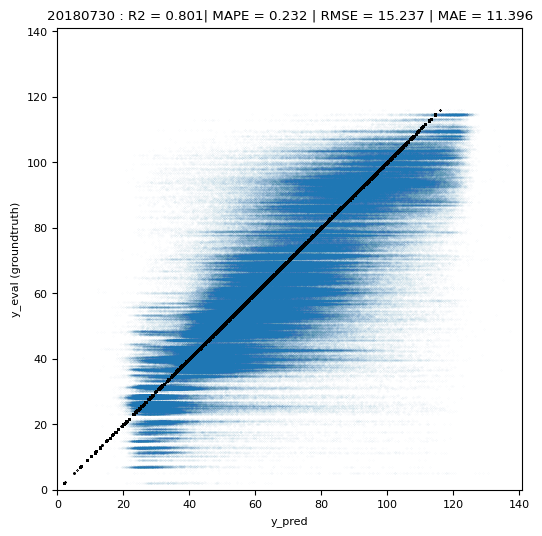

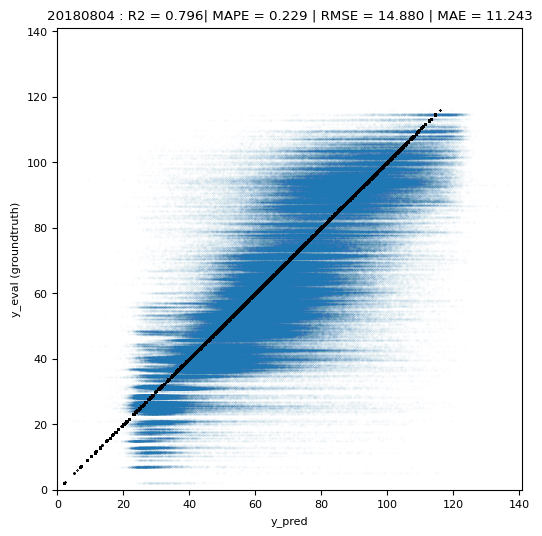

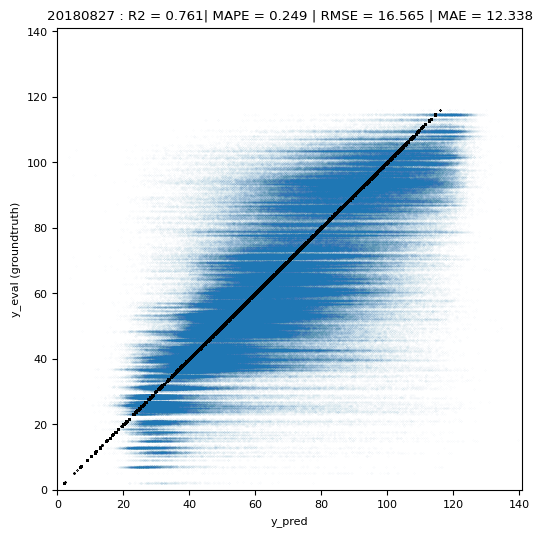

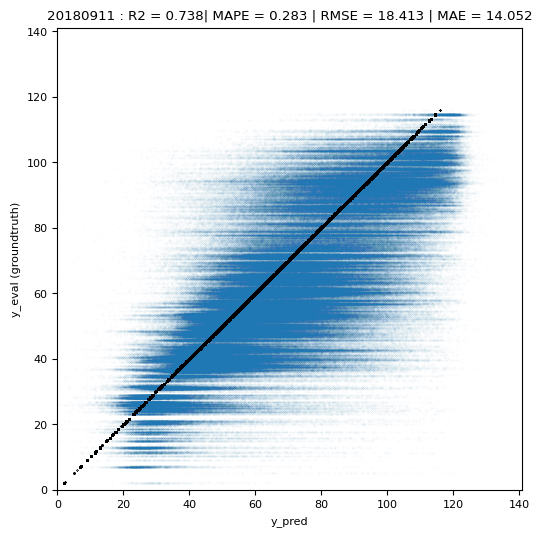

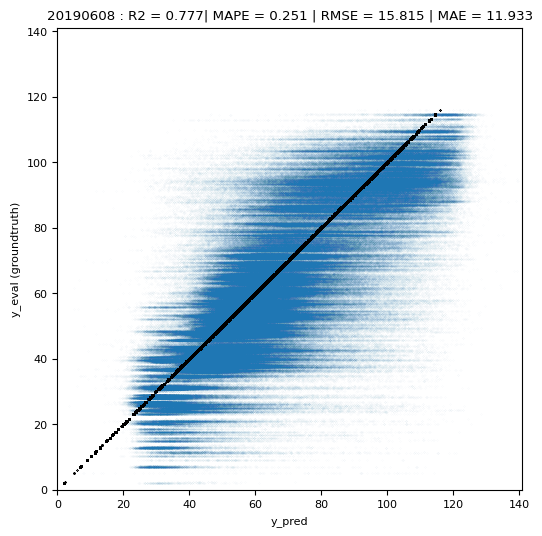

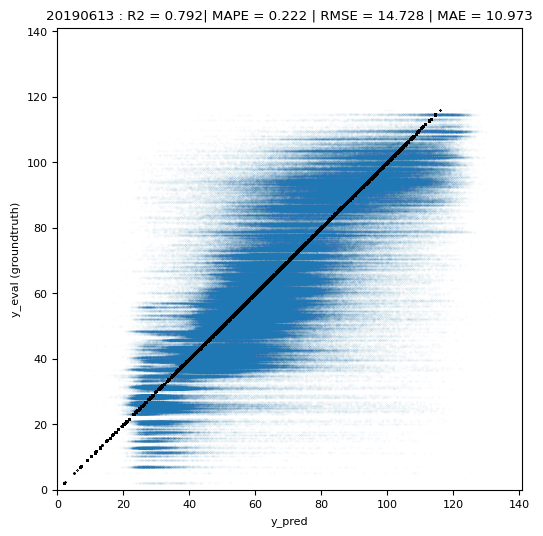

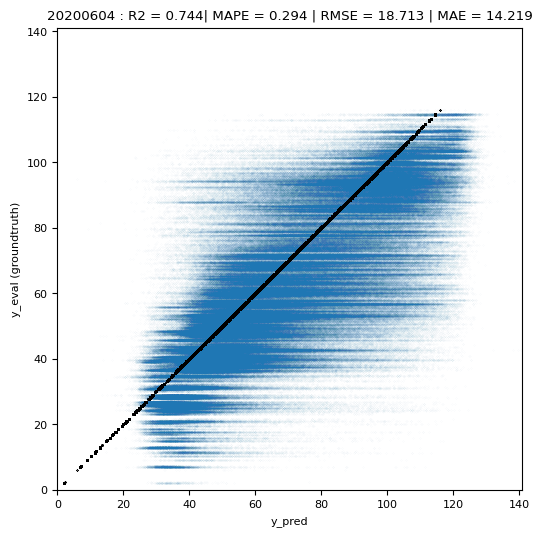

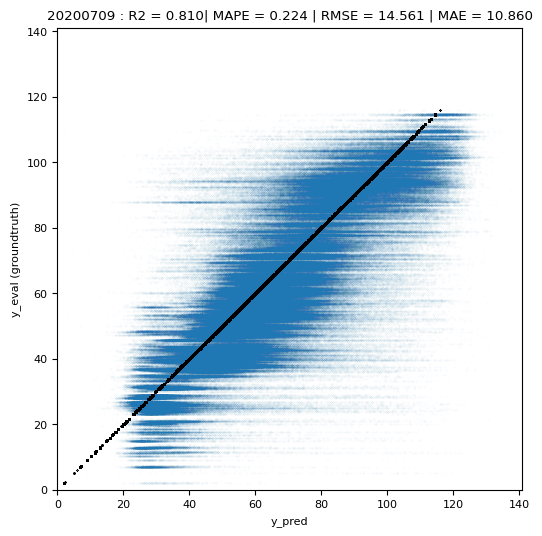

wandb: Network error (ReadTimeout), entering retry loop.


In [35]:
limits = [0, 141]
result_table = wandb.Table(columns=['name', 'R2', 'MAPE', 'RMSE', 'MAE'])

for i, name in enumerate(names):
    test_dataset = test_list[i]
    Y_eval = test_dataset[target]
    X_eval = test_dataset.drop(labels=[target, 'x', 'y'], axis=1)
    
    Y_pred = model.predict(X_eval) # test_dataset['var1']
    R2 = np.corrcoef(Y_eval, Y_pred)[0][1]
    MAPE = mean_absolute_percentage_error(Y_eval, Y_pred)
    RMSE = mean_squared_error(Y_eval, Y_pred, squared=False)
    MAE = mean_absolute_error(Y_eval, Y_pred)
    fig = plt.figure(figsize=(6,6)) 
    plt.scatter(Y_pred, Y_eval, s=0.01, alpha=0.1)
    plt.scatter(Y_eval, Y_eval, s=0.01, color='black')
    plt.xlabel('y_pred')
    plt.ylabel('y_eval (groundtruth)')
    plt.xlim(limits)
    plt.ylim(limits)
    plt.title(f'{name} : R2 = {R2:.3f}| MAPE = {MAPE:.3f} | RMSE = {RMSE:.3f} | MAE = {MAE:.3f}')
    
    result_table.add_data(name, R2, MAPE, RMSE, MAE)
    wandb.log({name: wandb.Image(fig)})